In [1]:
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, ConcatDataset
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps
import os, sys, math, random, copy, time
import datasets, custom_transforms, models
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, KFold


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

seed = 0
split_k_folds=10
flag_onlyFirstFold = True
np.random.seed(seed)
torch.manual_seed(seed)

# Parameters to Change
N_CLASSES = 2
BATCH_SIZE = 4
num_epochs_classifier=3
num_epochs_finetune=20
top_cutoff_percent = 0.15 # 0.08 COVID-Net paper by Wang et al.
flag_includePneumoniaPics = False

TRAINVAL_DATA_DIR = 'G:/DanielLam/DanielCustomNetwork/DanielDataSets_Reduced_256_Rajaraman_10KFold217/trainVal/'
save_folder_name =  os.path.join("15cutoff_fineTune", "VGG16_Rajaraman_Rajaraman_10KFold217_NORMALCOVIDonly")

print("Total Num Folds: {}".format(split_k_folds))
print("Total Num Epochs: {}".format(num_epochs_classifier + num_epochs_finetune))

cuda:0
Total Num Folds: 10
Total Num Epochs: 23


# Settings

In [2]:
# LOCKED
# Preprocessing settings:
interp_mode = torchvision.transforms.InterpolationMode.NEAREST
image_size_to_VGG =224 # resize input images to this size in VGG
model_name = "VGG"
num_channels = 3 # because VGG is trained on RGB images
unbias=True
limit_save_epoch_acc=0.80


# Learning Rates
betas = (0.9,0.999)
ini_lr= 1e-3
max_layers_to_freeze = 28 # 30 means that only the last linear classifier is left to train
class_weights = torch.Tensor([1, 1100/996]) # NONCOVID, COVID



# Data Preprocessing

In [3]:
# Data Preprocessing and Transforms
# Assumes importing images as PIL Images
normalize = torchvision.transforms.Normalize(
                                [0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])

class Equalise(object):
    # Histogram equalisation
    # Only works on PIL images
    def __init__(self, mask=None):
        self.mask = mask
    def __call__(self, image):
        return ImageOps.equalize(image, self.mask)
    
class ImageComplement(object):
    # Flip image intensities (i.e. black becomes white, white becomes black)
    # Assumes input image is a tensor with range[0,1]
    def __init__(self, probability=0.5):
        self.probability = probability
    def __call__(self, image):
        activate = np.random.uniform(0,1)
        if activate < self.probability:
            # Flip
            max_image = torch.max(image)
            min_image = torch.min(image)
            #print("min:{},max:{}".format(min_image, max_image))
            image = (image-min_image)/(max_image-min_image) # range [0,1]
            image = (1-image)*(max_image-min_image) + min_image # back to original range
        return image



train_transforms=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    custom_transforms.COVIDNetProcessing(top_cutoff_percent),
                                    torchvision.transforms.Resize(image_size_to_VGG, interpolation=interp_mode), # PIL image
                                    torchvision.transforms.CenterCrop(image_size_to_VGG),
                                    torchvision.transforms.RandomHorizontalFlip(), 
                                    torchvision.transforms.ColorJitter(brightness=0.1), # this jitters brightness
                                    torchvision.transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.9,1.1)),
                                    ImageComplement(),
                                    normalize,
                                    ])

val_transforms=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    custom_transforms.COVIDNetProcessing(top_cutoff_percent),
                                    torchvision.transforms.Resize(image_size_to_VGG, interpolation=interp_mode),
                                    torchvision.transforms.CenterCrop(image_size_to_VGG),
                                    normalize,
                                ])

# Network

In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, history=None, checkpoint_save_path = None,
                scheduler=None, is_inception=False):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    
    try:
        history_accuracy = {"train":history["accuracy"]["train"], "val":history["accuracy"]["val"]}
        history_loss = {"train":history["loss"]["train"], "val":history["loss"]["val"]}
    except:
        history_accuracy = {"train":[], "val":[]}
        history_loss = {"train":[], "val":[]}
    
    best_loss = 1.0
    best_acc = 0.0
    # Is this continuing from former training?
    pretrained_epochs = len(history_accuracy["train"])
    
    for epoch in range(pretrained_epochs+1, pretrained_epochs+num_epochs+1):
        print('Epoch {}/{}'.format(epoch, pretrained_epochs+num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in dataloaders.keys():
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs=data["image"]
                labels=data["label"]
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                labels = labels.detach().cpu()
                preds = preds.detach().cpu()
                running_loss += loss.item() * inputs.size(0)
                # for each element in preds, check is equal to each element in labels.data
                running_corrects += torch.sum(torch.eq(preds, labels))
                #print(running_corrects)
                
            epoch_loss = running_loss / len(dataloaders[phase].sampler)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler)
            print("Length of {} dataset: {}".format(phase, len(dataloaders[phase].sampler)))
            
            # Record histories
            history_accuracy[phase].append(epoch_acc)
            history_loss[phase].append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            best_model_wts = copy.deepcopy(model.state_dict())
            save_outputs = {
                    'epoch': epoch,
                    'model_state_dict': best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'N_CLASSES': N_CLASSES,
                    'BATCH_SIZE': BATCH_SIZE,
                    'ini_lr': ini_lr,
                    'max_layers_to_freeze':max_layers_to_freeze,
                    'class_weights':class_weights,
                    'random_seed': seed
            }
            if phase == 'val' and epoch_acc > limit_save_epoch_acc and checkpoint_save_path is not None:
                best_loss = epoch_loss
                best_acc = epoch_acc
                print("Achieved current lowest loss of: {} ; accuracy = {}".format(best_loss, epoch_acc))
                saved_checkpoint = os.path.join(checkpoint_save_path,
                             'balance[epoch_{}_loss_{:.3f}_acc_{:.3f}].pt'.format((epoch), history_loss[phase][-1],
                                                                                        history_accuracy[phase][-1]))
                torch.save(save_outputs, saved_checkpoint)
                print("Saved checkpoint: {}".format(saved_checkpoint))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    history = {"accuracy":history_accuracy, "loss":history_loss}
    return model, history, save_outputs


def set_parameter_requires_grad(model, feature_extracting):
    # If feature extracting only.
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

import datasets
import models
splits=StratifiedKFold(n_splits=split_k_folds,shuffle=True,random_state=42)
foldperf={}
def pneumoniaPath(TRAINVAL_DATA_DIR,  flag_includePneumoniaPics):
    if flag_includePneumoniaPics:
        return os.path.join(TRAINVAL_DATA_DIR,"PNEUMONIA")
    else:
        return None
trainVal_dataset = datasets.Coviddataset(normal_path=os.path.join(TRAINVAL_DATA_DIR,"NORMAL"),
                                      pneumonia_path= pneumoniaPath(TRAINVAL_DATA_DIR, flag_includePneumoniaPics),
                                      covid_path=os.path.join(TRAINVAL_DATA_DIR,"COVID"),
                                      transform = None,
                                     NClasses=N_CLASSES, unbias=unbias,channels=num_channels, display_console=True)
for fold, (train_idx,val_idx) in enumerate(splits.split(X=np.arange(len(trainVal_dataset)), y=trainVal_dataset.labels)):
    print('Fold {}'.format(fold + 1))
    
    # Subset sample from dataset
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    dl_training = DataLoader(datasets.Coviddataset(normal_path=os.path.join(TRAINVAL_DATA_DIR,"NORMAL"),
                                      pneumonia_path=pneumoniaPath(TRAINVAL_DATA_DIR, flag_includePneumoniaPics),
                                      covid_path=os.path.join(TRAINVAL_DATA_DIR,"COVID"),
                                      transform = train_transforms,
                                     NClasses=N_CLASSES, unbias=unbias,channels=num_channels, display_console=False),
                             batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=0)
    dl_validation = DataLoader(datasets.Coviddataset(normal_path=os.path.join(TRAINVAL_DATA_DIR,"NORMAL"),
                                      pneumonia_path=pneumoniaPath(TRAINVAL_DATA_DIR, flag_includePneumoniaPics),
                                      covid_path=os.path.join(TRAINVAL_DATA_DIR,"COVID"),
                                      transform = val_transforms,
                                     NClasses=N_CLASSES, unbias=unbias,channels=num_channels, display_console=False),
                             batch_size=BATCH_SIZE, sampler=test_sampler, num_workers=0)
    
    dataloaders = {'train':dl_training,'val':dl_validation}
    
    # DEBUGGING
    for phase in dataloaders.keys():
        sample = next(iter(dataloaders[phase]))
        print(sample.keys())
        out = torchvision.utils.make_grid(sample["image"])
        #imshow(out)
    
    # First training using Adam
    # Model
    model = models.VGG16_Rajaraman(N_CLASSES, max_layer_to_freeze=30, verbose=False) # freeze all layers
    model = model.to(device)
    
    # Loss
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

    # Observe that all parameters are being optimized
    optimizer = torch.optim.Adam(model.parameters(), lr=ini_lr, betas=betas)

    # Deterministic
    torch.backends.cudnn.benchmark = False
    
    # Train model & save outputs
    model, history, save_outputs = train_model(model, dataloaders, criterion, optimizer, num_epochs_classifier,
                                 history=None,
                                 checkpoint_save_path=None,
                                 is_inception=(model_name=="inception"))
    print("+++++++")
    print("Fine-Tuning")
    print("+++++++")
    # UnFreeze layers
    model.freeze_layers_VGG16(layers=np.arange(24,30), freeze=False) # unfreeze convblock 5
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Parameters total: ',total_num)
    print('Parameters trainable: ',trainable_num)
    # Train using slower method
    optimizer = torch.optim.SGD(model.parameters(), lr=0.5e-5, weight_decay=0.1)
    model, history, save_outputs = train_model(model, dataloaders, criterion, optimizer, num_epochs_finetune,
                                 history=history,
                                 checkpoint_save_path=None,
                                 is_inception=(model_name=="inception"))
    foldperf['fold{}'.format(fold+1)] = history
    
    # Saving Output
    checkpoint_save_path=os.path.join('checkpoints', str(N_CLASSES)+"Class", save_folder_name)
    a = Path(checkpoint_save_path)
    a.mkdir(parents=True, exist_ok=True)
    
    save_filename = "Fold{}[classifier{}_finetune{}].pt".format(fold+1, num_epochs_classifier, num_epochs_finetune)
    saved_checkpoint = os.path.join(checkpoint_save_path, save_filename)
    torch.save(save_outputs, saved_checkpoint)
    print("Saved checkpoint: {}".format(saved_checkpoint))
    
    if flag_onlyFirstFold:
        print("Breaking loop.")
        break

None Path
RAW DATASET STATISTICS:-----------
Normal:1100, Pneumonia:0, COVID:996
2-Class Dataset Statistics:-----------
Noncovid:1100, COVID:996
Fold 1
dict_keys(['name', 'image', 'label'])
dict_keys(['name', 'image', 'label'])
Parameters total:  14715714
Parameters trainable:  1026
Epoch 1/3
----------
Length of train dataset: 1886
train Loss: 0.4992 Acc: 0.7932
Length of val dataset: 210
val Loss: 0.2934 Acc: 0.9619
Epoch 2/3
----------
Length of train dataset: 1886
train Loss: 0.3442 Acc: 0.8823
Length of val dataset: 210
val Loss: 0.2428 Acc: 0.9381
Epoch 3/3
----------
Length of train dataset: 1886
train Loss: 0.3044 Acc: 0.8865
Length of val dataset: 210
val Loss: 0.2089 Acc: 0.9524
Training complete in 1m 29s
Best val Acc: 0.000000
+++++++
Fine-Tuning
+++++++
Parameters total:  14715714
Parameters trainable:  7080450
Epoch 4/23
----------
Length of train dataset: 1886
train Loss: 0.2957 Acc: 0.8897
Length of val dataset: 210
val Loss: 0.2072 Acc: 0.9571
Epoch 5/23
----------
Len

Training complete
Performance of 1 fold cross validation
Average Training Loss: 0.286 	 Average Test Loss: 0.205 	 Average Training Acc: 0.894 	 Average Test Acc: 0.962
Best fold: 1


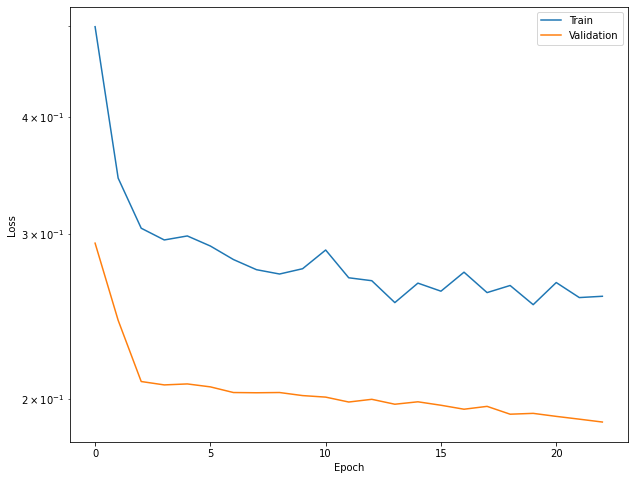

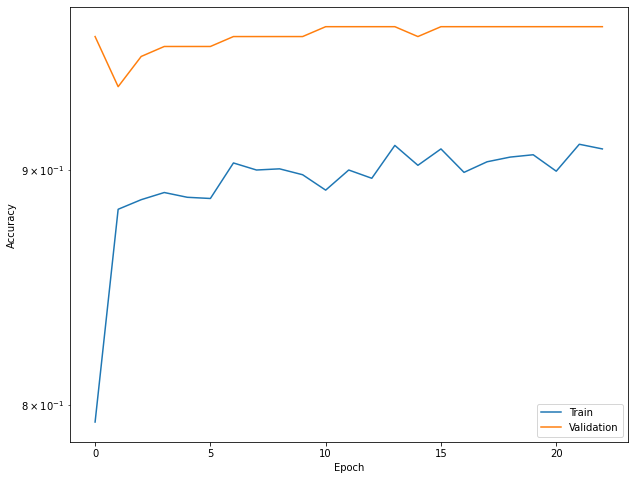

In [5]:
print("Training complete")
# Find the best fold
flag_debug=False
output_save_directory=checkpoint_save_path

# AVERAGE PERFORMANCE
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=len(foldperf.keys())#split_k_folds
for f in range(1,k+1):
    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['loss']['train']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['loss']['val']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['accuracy']['train']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['accuracy']['val']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}"
      .format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))
print("Best fold: {}".format(np.argmax(testa_f)+1))

import json
save_dict = {"Loss":{"Training":np.mean(tl_f),"Validation":np.mean(testl_f)}, 
             "Accuracy":{"Training":np.mean(ta_f), "Validation":np.mean(testa_f)}}
with open(os.path.join(output_save_directory,'data.json'), 'w') as fp:
    json.dump(save_dict, fp)

# Averaging accuracy and loss
diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}
for i in range(0,num_epochs_classifier+num_epochs_finetune):
    diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['loss']['train'][i] for f in range(k)]))
    diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['loss']['val'][i] for f in range(k)]))
    diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['accuracy']['train'][i] for f in range(k)]))
    diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['accuracy']['val'][i] for f in range(k)]))

# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['test_loss_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, "average_fold_loss"+".png"))
plt.show()

# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['test_acc_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.grid()
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, "average_fold_accuracy"+".png"))
plt.show()

In [6]:
print(len(foldperf['fold1']['loss']['val']))

print("Length of validation idx: {}".format(len(val_idx)))
len(dl_validation.sampler)

23
Length of validation idx: 210


210

In [7]:
# Graph Visualisation
import matplotlib.pyplot as plt

epoch_list= list(i for i in range(1,num_epochs+1))

fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].set(title='Train/Val Loss', xlabel='Epoch', ylabel='Loss' )
ax[0].plot(epoch_list, history["loss"]['train'],linewidth=2,linestyle=':',label='Train Loss', marker='o')
ax[0].plot(epoch_list, history["loss"]['val'], linewidth=1, linestyle='--', label='Val Loss', marker='+')
ax[0].legend(loc=2)

ax[1].set(title='Train/Val Acc', xlabel='Epoch', ylabel='Acc' )
ax[1].plot(epoch_list, history["accuracy"]['train'], linewidth=2, linestyle=':', label='Train Acc', marker='o')
ax[1].plot(epoch_list, history["accuracy"]['val'], linewidth=1, linestyle='--', label='Val Acc', marker='+')
ax[1].legend(loc=2)
plt.savefig(os.path.join(checkpoint_save_path,"lossaccpic_"+str(N_CLASSES)+"class.png"), bbox_inches='tight')

plt.show()

NameError: name 'num_epochs' is not defined